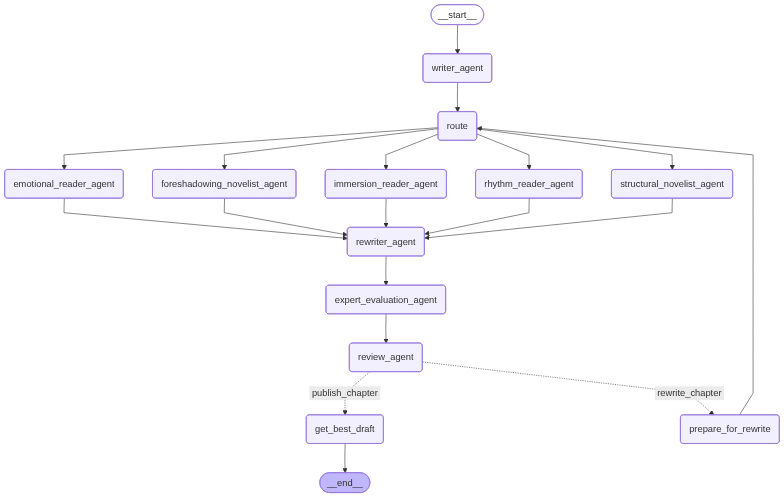

In [6]:
import traceback

from IPython.core.display_functions import display
from langgraph.constants import END
from langgraph.graph import StateGraph

import os
import dotenv

from agents.evaluation import expert_evaluation_agent
from agents.novelists import foreshadowing_novelist_agent, structural_novelist_agent
from agents.readers import immersion_reader_agent, rhythm_reader_agent, emotional_reader_agent
from agents.review import review_agent
from agents.writer import rewriter_agent, writer_agent
from helper import publish_chapter, route, prepare_for_rewrite, decide_to_publish_or_rewrite, get_best_draft
from state import StoryState


dotenv.load_dotenv()

def get_workflow():
    workflow = StateGraph(StoryState)

    workflow.set_entry_point("writer_agent")

    workflow.add_node("writer_agent", writer_agent)
    workflow.add_node("emotional_reader_agent", emotional_reader_agent)
    workflow.add_node("rhythm_reader_agent", rhythm_reader_agent)
    workflow.add_node("immersion_reader_agent", immersion_reader_agent)
    workflow.add_node("structural_novelist_agent", structural_novelist_agent)
    workflow.add_node("foreshadowing_novelist_agent", foreshadowing_novelist_agent)
    workflow.add_node("review_agent", review_agent)
    workflow.add_node("expert_evaluation_agent", expert_evaluation_agent)
    workflow.add_node("rewriter_agent", rewriter_agent)
    workflow.add_node("route", route)
    workflow.add_node("prepare_for_rewrite", prepare_for_rewrite)
    workflow.add_node("get_best_draft", get_best_draft)

    workflow.add_edge("writer_agent", "route")
    workflow.add_edge("route", "emotional_reader_agent")
    workflow.add_edge("route", "rhythm_reader_agent")
    workflow.add_edge("route", "immersion_reader_agent")
    workflow.add_edge("route", "structural_novelist_agent")
    workflow.add_edge("route", "foreshadowing_novelist_agent")
    workflow.add_edge("emotional_reader_agent", "rewriter_agent")
    workflow.add_edge("rhythm_reader_agent", "rewriter_agent")
    workflow.add_edge("immersion_reader_agent", "rewriter_agent")
    workflow.add_edge("structural_novelist_agent", "rewriter_agent")
    workflow.add_edge("foreshadowing_novelist_agent", "rewriter_agent")
    workflow.add_edge("rewriter_agent", "expert_evaluation_agent")
    workflow.add_edge("expert_evaluation_agent", "review_agent")

    workflow.add_conditional_edges(
        "review_agent",
        decide_to_publish_or_rewrite,  # 使用新的、只做判断的函数
        {
            "publish_chapter": "get_best_draft",
            # 如果需要重写，先跳转到状态更新节点
            "rewrite_chapter": "prepare_for_rewrite"
        }
    )
    workflow.add_edge("prepare_for_rewrite", "route")
    workflow.add_edge("get_best_draft", END)

    app = workflow.compile()
    return app

# def test(state:StoryState):
#     return {"revised_draft":"asdasdasfafas"}
# def get_workflow():
#     workflow = StateGraph(StoryState)
#
#     workflow.set_entry_point("test")
#
#     workflow.add_node("test", test)
#
#
#     workflow.add_edge("test", END)
#
#
#     app = workflow.compile()
#     return app
app = get_workflow()
# 方式1: 直接在Jupyter中显示交互式流程图
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.core.display import Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)